# TODO(Lorenzo): Set title and general description for the notebook

In [1]:
import logging
import operator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb

from fedmoe_plots.data_analysis import ColumnNotFoundError, get_perplexity_versus_tokens
from fedmoe_plots.parameter_counting import compute_parameter_counts
from fedmoe_plots.plotting_utils import configure_logging_for_jupyter
from fedmoe_plots.wandb_utils import (
    ClientRunNotFoundError,
    download_photon_metrics,
    download_wandb_whole_history,
    get_clientrun_property_from_config,
    get_experts_global_batch_size,
    get_n_local_experts,
    get_non_experts_global_batch_size,
    get_run_uuid_from_config,
    remove_runs_by_regex,
    set_embedding_ln_to_config,
)

configure_logging_for_jupyter()

log = logging.getLogger("mup_completep_scaling.ipynb")

EXCLUDE_INCOMPLETE_RUNS = True

In [2]:
FOUR_EXPERTS_RUNS = [
    "(^tune-sigma_moe_4e_44m)",
    "(^tune-deptoe_4e_256)",
    "(^deptoe_4e_44m_mpt-base)",
    "(^tune-deptoe_4e_128)",
    "(^tune-deptoe_4e_depth)",
    "(^tune-deptoe_4e_max)",
    "(^tune-deptoe_4e_width)",
]

EIGHT_EXPERTS_RUNS = [
    "(^tune-deptoe_8e_128)",
    "(^tune-deptoe_8e_256)",
    "(^tune-deptoe_8e_base)",
    "(^tune-deptoe_8e_mpt-base)",
]

RUNS_REGEX = [
    "(^tune-mpt_18m)",
    "(^tune-mpt_1B)",
    "(^tune-mpt_200m)",
    "(^tune-mpt_3m)",
    "(^tune-peri_mpt_18m)",
    "(^tune-peri_mpt_200m)",
    "(^tune-peri_mpt_3m)",
    *FOUR_EXPERTS_RUNS,
    *EIGHT_EXPERTS_RUNS,
]
RUNS_NO_PERI_LN = [
    "(^tune-mpt_3m)",
    "(^tune-mpt_18m)",
    "(^tune-mpt_200m)",
    "(^tune-mpt_1B)",
]
RUNS_W_PERI_LN = set(RUNS_REGEX) - set(RUNS_NO_PERI_LN)

In [3]:
api = wandb.Api(timeout=100)
full_runs_regex = "|".join(RUNS_REGEX)
runs = api.runs(
    path="camlsys/photon",
    filters={"display_name": {"$regex": f"{full_runs_regex}"}},
)
log.info("Found %d runs matching the regex: %s", len(runs), full_runs_regex)

mup_completep_scaling.ipynb - INFO - Found 232 runs matching the regex: (^deptoe_4e_44m_mpt-base)|(^tune-deptoe_4e_128)|(^tune-deptoe_4e_256)|(^tune-deptoe_4e_depth)|(^tune-deptoe_4e_max)|(^tune-deptoe_4e_width)|(^tune-deptoe_8e_128)|(^tune-deptoe_8e_256)|(^tune-deptoe_8e_base)|(^tune-deptoe_8e_mpt-base)|(^tune-mpt_18m)|(^tune-mpt_1B)|(^tune-mpt_200m)|(^tune-mpt_3m)|(^tune-peri_mpt_18m)|(^tune-peri_mpt_200m)|(^tune-peri_mpt_3m)|(^tune-sigma_moe_4e_44m)


In [4]:
def _get_n_experts(config: dict):
    try:
        return config["llm_config"]["model"]["ffn_config"]["ff_n_experts"]
    except KeyError:
        return 1


def _get_d_model_base(config: dict) -> int:
    d_model = config["llm_config"]["model"]["d_model"]
    assert d_model is not None, "d_model should not be None"
    assert isinstance(d_model, int), "d_model should be an integer"
    width_multiplier = config["llm_config"]["model"]["mup_config"][
        "mup_width_multiplier"
    ]
    assert width_multiplier is not None, "mup_width_multiplier should not be None"
    assert isinstance(
        width_multiplier, int
    ), "mup_width_multiplier should be an integer"
    return d_model // width_multiplier

In [5]:
unique_depth_multiplier = {
    get_clientrun_property_from_config(
        run,
        get_property_fn=lambda config: config["llm_config"]["model"]["mup_config"][
            "completep_depth_multiplier"
        ],
    )
    for run in runs
}
unique_width_multiplier = {
    get_clientrun_property_from_config(
        run,
        get_property_fn=lambda config: config["llm_config"]["model"]["mup_config"][
            "mup_width_multiplier"
        ],
    )
    for run in runs
}
unique_lr = {
    get_clientrun_property_from_config(
        run,
        get_property_fn=lambda config: config["llm_config"]["optimizer"]["lr"],
    )
    for run in runs
}
unique_batch_size = {
    get_clientrun_property_from_config(
        run,
        get_property_fn=lambda config: config["llm_config"]["global_train_batch_size"],
    )
    for run in runs
}
unique_n_experts = {
    get_clientrun_property_from_config(
        run,
        get_property_fn=_get_n_experts,
    )
    for run in runs
}
unique_peri_ln = {
    get_clientrun_property_from_config(
        run,
        get_property_fn=lambda config: config["llm_config"]["model"]["use_peri_norm"],
    )
    for run in runs
}
unique_embedding_ln = {
    get_clientrun_property_from_config(
        run,
        get_property_fn=lambda config: config["llm_config"]["model"][
            "use_embedding_norm"
        ],
    )
    for run in runs
}
unique_no_bias = {
    get_clientrun_property_from_config(
        run,
        get_property_fn=lambda config: config["llm_config"]["model"]["no_bias"],
    )
    for run in runs
}
unique_d_model_base = {
    get_clientrun_property_from_config(
        run,
        get_property_fn=_get_d_model_base,
    )
    for run in runs
}
log.info(
    "Unique depth multipliers: %s",
    ", ".join(str(dm) for dm in unique_depth_multiplier if dm is not None),
)
log.info(
    "Unique width multipliers: %s",
    ", ".join(str(wm) for wm in unique_width_multiplier if wm is not None),
)
log.info(
    "Unique learning rates: %s",
    ", ".join(str(lr) for lr in unique_lr if lr is not None),
)
log.info(
    "Unique batch sizes: %s",
    ", ".join(str(bs) for bs in unique_batch_size if bs is not None),
)
log.info(
    "Unique number of experts: %s",
    ", ".join(str(ne) for ne in unique_n_experts if ne is not None),
)
log.info(
    "Unique use_peri_norm: %s",
    ", ".join(str(p) for p in unique_peri_ln if p is not None),
)
log.info(
    "Unique use_embedding_norm: %s",
    ", ".join(str(en) for en in unique_embedding_ln if en is not None),
)
log.info(
    "Unique no_bias: %s",
    ", ".join(str(nb) for nb in unique_no_bias if nb is not None),
)
log.info(
    "Unique d_model_base: %s",
    ", ".join(str(dm) for dm in unique_d_model_base if dm is not None),
)

mup_completep_scaling.ipynb - INFO - Unique depth multipliers: 1, 6
mup_completep_scaling.ipynb - INFO - Unique width multipliers: 8, 1
mup_completep_scaling.ipynb - INFO - Unique learning rates: 0.00390625, 0.001953125, 0.015625, 0.0078125, 0.0009765625, 0.00048828125, 0.03125, 0.0625, 0.009765625, 0.01171875, 0.0055243, 0.002762135864, 0.013671875, 0.02209708691, 0.011048543456039806, 0.011049, 0.005524271728019903
mup_completep_scaling.ipynb - INFO - Unique batch sizes: 512, 256, 128
mup_completep_scaling.ipynb - INFO - Unique number of experts: 8, 1, 4
mup_completep_scaling.ipynb - INFO - Unique use_peri_norm: False, True
mup_completep_scaling.ipynb - INFO - Unique use_embedding_norm: False, True
mup_completep_scaling.ipynb - INFO - Unique no_bias: True
mup_completep_scaling.ipynb - INFO - Unique d_model: 256, 2048


In [9]:
# Data collection and processing for expert density analysis

log.info("🔄 Starting data collection and processing...")
log.info("Found %s runs to process", len(runs))

results_list = []

for i, run in enumerate(runs):
    log.info(
        "📊 Processing run %s/%s: %s",
        i + 1,
        len(runs),
        get_run_uuid_from_config(run),
    )
    try:
        # Extract configuration parameters (depth multiplier, width multiplier,
        # learning rate, batch size, number of experts, hidden dimension of the model,
        # run UUID)
        run_uuid = get_run_uuid_from_config(run)
        depth_multiplier = get_clientrun_property_from_config(
            run,
            get_property_fn=lambda config: config["llm_config"]["model"]["mup_config"][
                "completep_depth_multiplier"
            ],
        )
        width_multiplier = get_clientrun_property_from_config(
            run,
            get_property_fn=lambda config: config["llm_config"]["model"]["mup_config"][
                "mup_width_multiplier"
            ],
        )
        learning_rate = get_clientrun_property_from_config(
            run,
            get_property_fn=lambda config: config["llm_config"]["optimizer"]["lr"],
        )
        global_train_batch_size = get_clientrun_property_from_config(
            run,
            get_property_fn=lambda config: config["llm_config"][
                "global_train_batch_size"
            ],
        )
        n_total_experts = get_clientrun_property_from_config(
            run,
            get_property_fn=_get_n_experts,
        )
        d_model_base = get_clientrun_property_from_config(
            run,
            get_property_fn=_get_d_model_base,
        )
        peri_ln = get_clientrun_property_from_config(
            run,
            get_property_fn=lambda config: config["llm_config"]["model"][
                "use_peri_norm"
            ],
        )
        embedding_ln = get_clientrun_property_from_config(
            run,
            get_property_fn=lambda config: config["llm_config"]["model"][
                "use_embedding_norm"
            ],
        )
        no_bias = get_clientrun_property_from_config(
            run,
            get_property_fn=lambda config: config["llm_config"]["model"]["no_bias"],
        )

        # Calculate derived metrics (number of total trainable parameters, number of
        # non-expert parameters, number of expert parameters, number of non embedding
        # parameters, number of embedding parameters)
        run_config = run.config
        assert run_config is not None, "Run config must not be None"
        assert isinstance(
            run_config,
            dict,
        ), f"Run config must be a dictionary, not {type(run_config)}"
        llm_config = run_config.get("llm_config", {})
        assert llm_config is not None, "Model config must not be None"
        assert isinstance(
            llm_config,
            dict,
        ), f"Model config must be a dictionary, not {type(llm_config)}"
        parameter_counts = compute_parameter_counts(llm_config)
        n_trainable_parameters = parameter_counts.n_trainable
        n_non_expert_parameters = parameter_counts.n_non_experts
        n_expert_parameters = parameter_counts.n_experts
        n_non_embedding_parameters = parameter_counts.n_non_embedding
        n_embedding_parameters = parameter_counts.n_embedding

        # Download and process data
        log.info("🔽 Downloading data for %s...", run_uuid)

        try:
            # Download photon metrics for the run
            assert run_uuid is not None, "Run UUID must not be None"
            assert isinstance(
                run_uuid,
                str,
            ), f"Run UUID must be a string not a {type(run_uuid)}"
            run_df = download_wandb_whole_history(
                run=run,
            )

            # Try to get perplexity vs tokens data
            tokens, perplexity = get_perplexity_versus_tokens(
                client_metrics_df=run_df,
                n_clients_per_round=1,
            )

            if len(tokens) == 0 or len(perplexity) == 0:
                log.warning("❌ Empty data arrays for %s", run_uuid)
                continue

            # Calculate metrics
            final_perplexity = (
                perplexity.iloc[-1] if len(perplexity) > 0 else float("nan")
            )
            total_tokens = tokens.iloc[-1] if len(tokens) > 0 else 0
            n_data_points = len(tokens)

            log.info(
                (
                    "   ✅ Data processed: %d points,"
                    " Final perplexity: %.4f, Total tokens: %.0f"
                ),
                n_data_points,
                final_perplexity,
                total_tokens,
            )

            # Store results
            results_list.append(
                {
                    "run_uuid": str(run_uuid),
                    "d_model_base": d_model_base,
                    "n_total_experts": n_total_experts,
                    "depth_multiplier": depth_multiplier,
                    "width_multiplier": width_multiplier,
                    "peri_ln": peri_ln,
                    "embedding_ln": embedding_ln,
                    "no_bias": no_bias,
                    "learning_rate": learning_rate,
                    "global_train_batch_size": global_train_batch_size,
                    "n_trainable_parameters": n_trainable_parameters,
                    "n_non_expert_parameters": n_non_expert_parameters,
                    "n_expert_parameters": n_expert_parameters,
                    "n_non_embedding_parameters": n_non_embedding_parameters,
                    "n_embedding_parameters": n_embedding_parameters,
                    "final_perplexity": final_perplexity,
                    "total_tokens": total_tokens,
                    "n_data_points": n_data_points,
                    "tokens": (
                        tokens.tolist() if hasattr(tokens, "tolist") else list(tokens)
                    ),
                    "perplexity": (
                        perplexity.tolist()
                        if hasattr(perplexity, "tolist")
                        else list(perplexity)
                    ),
                },
            )

        except ColumnNotFoundError:
            log.exception(
                "   ⚠️ Column not found in client metrics DataFrame for %s. "
                "We assume this run crashed and doesn't have the expected data.",
                run_uuid,
                stack_info=True,
            )

            # Remove this run from WandB runs to avoid further processing
            if run.state != "running":
                log.info(
                    "Removing run %s with display name %s.",
                    run.id,
                    run.display_name,
                )
                run.delete()
            continue

        except Exception:
            log.exception("   ❌ Error processing %s", run_uuid, stack_info=True)
            continue

    except Exception:
        assert run is not None, "Run must not be None"
        log.exception(
            "   ❌ Error extracting config for run %s",
            run.name,
            stack_info=True,
        )
        continue

log.info("\n✅ Data collection completed!")
log.info("Successfully processed %d out of %d runs", len(results_list), len(runs))

mup_completep_scaling.ipynb - INFO - 🔄 Starting data collection and processing...
mup_completep_scaling.ipynb - INFO - Found 232 runs to process
mup_completep_scaling.ipynb - INFO - 📊 Processing run 1/232: tune-mpt_3m-20250716_002129
mup_completep_scaling.ipynb - INFO - 🔽 Downloading data for tune-mpt_3m-20250716_002129...
mup_completep_scaling.ipynb - INFO -    ✅ Data processed: 1024 points, Final perplexity: 36.5524, Total tokens: 1072693248
mup_completep_scaling.ipynb - INFO - 📊 Processing run 2/232: tune-mpt_3m-20250716_002209
mup_completep_scaling.ipynb - INFO - 🔽 Downloading data for tune-mpt_3m-20250716_002209...
mup_completep_scaling.ipynb - INFO -    ✅ Data processed: 1024 points, Final perplexity: 35.9842, Total tokens: 1072693248
mup_completep_scaling.ipynb - INFO - 📊 Processing run 3/232: tune-mpt_3m-20250716_002249
mup_completep_scaling.ipynb - INFO - 🔽 Downloading data for tune-mpt_3m-20250716_002249...
mup_completep_scaling.ipynb - INFO -    ✅ Data processed: 1024 points

In [10]:
log.info("\n=== Summary ===")
log.info(
    "Successfully processed %d out of %d runs",
    len(results_list),
    len(runs),
)

incomplete_runs = []
complete_runs = []

# Check for runs that didn't reach 1 billion tokens and log warnings
if results_list:
    log.info("\n⚠️  TOKEN COUNT ANALYSIS ⚠️")
    log.info("=" * 60)

    billion_tokens = 1e9

    for result in results_list:
        if result["total_tokens"] < billion_tokens:
            incomplete_runs.append(result)
        else:
            complete_runs.append(result)

    if incomplete_runs:
        log.warning(
            "🔴 WARNING: %d run(s) did NOT reach 1 billion tokens:",
            len(incomplete_runs),
        )
        log.info("-" * 60)

        for i, result in enumerate(incomplete_runs, 1):
            log.info("\n%s. Run UUID: %s", i, result["run_uuid"])
            log.info(
                "   Total Tokens: %s (%.3fB)",
                format(result["total_tokens"], ","),
                result["total_tokens"] / 1e9,
            )
            log.info(
                "   Completion: %.1f%% of 1B tokens",
                result["total_tokens"] / billion_tokens * 100,
            )
            log.info("   📋 Full Configuration:")
            log.info("      • Run UUID: %s", result["run_uuid"])
            log.info(
                "      • Hidden dimension of the base model: %s", result["d_model_base"]
            )
            log.info("      • Use Peri-LN: %s", result["peri_ln"])
            log.info("      • Use Embedding-LN: %s", result["embedding_ln"])
            log.info("      • No Bias: %s", result["no_bias"])
            log.info("      • Total Experts: %s", result["n_total_experts"])
            log.info("      • Depth Multiplier: %s", result["depth_multiplier"])
            log.info("      • Width Multiplier: %s", result["width_multiplier"])
            log.info("      • Learning Rate: %s", result["learning_rate"])
            log.info(
                "      • Global Train Batch Size: %s",
                result["global_train_batch_size"],
            )
            log.info(
                "      • Trainable Parameters: %s",
                format(result["n_trainable_parameters"], ","),
            )
            log.info(
                "      • Non-Expert Parameters: %s",
                format(result["n_non_expert_parameters"], ","),
            )
            log.info(
                "      • Expert Parameters: %s",
                format(result["n_expert_parameters"], ","),
            )
            log.info("      • Final Perplexity: %.4f", result["final_perplexity"])
            log.info("      • Data Points: %s", result["n_data_points"])

    if complete_runs:
        log.info(
            "✅ %d run(s) successfully reached 1+ billion tokens:",
            len(complete_runs),
        )
        for result in complete_runs:
            log.info(
                "   • %s: %d tokens (%.3fB)",
                result["run_uuid"],
                result["total_tokens"],
                result["total_tokens"] / 1e9,
            )

    log.info("\n📊 Token Count Summary:")
    log.info("   • Complete runs (≥1B tokens): %d", len(complete_runs))
    log.info("   • Incomplete runs (<1B tokens): %d", len(incomplete_runs))
    if results_list:
        avg_tokens = sum(r["total_tokens"] for r in results_list) / len(results_list)
        log.info(
            "   • Average tokens across all runs: %.0f (%.3fB)",
            avg_tokens,
            avg_tokens / 1e9,
        )

this_cell_results_list = results_list
if EXCLUDE_INCOMPLETE_RUNS:
    this_cell_results_list = complete_runs

# Convert to DataFrame for easier analysis
if this_cell_results_list:
    results_df = pd.DataFrame(this_cell_results_list)
    log.info("\nResults DataFrame shape: %s", results_df.shape)
    log.info("\nConfiguration summary:")
    summary_cols = [
        "run_uuid",
        "d_model_base",
        "peri_ln",
        "embedding_ln",
        "no_bias",
        "n_total_experts",
        "depth_multiplier",
        "width_multiplier",
        "learning_rate",
        "global_train_batch_size",
        "final_perplexity",
        "n_trainable_parameters",
    ]
    log.info(results_df[summary_cols].to_string(index=False, float_format="%.4f"))
else:
    log.info("No results to analyze")
    results_df = pd.DataFrame()

mup_completep_scaling.ipynb - INFO - 
=== Summary ===
mup_completep_scaling.ipynb - INFO - Successfully processed 232 out of 232 runs
mup_completep_scaling.ipynb - INFO - 
⚠️  TOKEN COUNT ANALYSIS ⚠️
mup_completep_scaling.ipynb - INFO - ============================================================
mup_completep_scaling.ipynb - WARNING - 🔴 WARNING: 28 run(s) did NOT reach 1 billion tokens:
mup_completep_scaling.ipynb - INFO - ------------------------------------------------------------
mup_completep_scaling.ipynb - INFO - 
1. Run UUID: tune-mpt_3m-20250717_055714
mup_completep_scaling.ipynb - INFO -    Total Tokens: 962,592,768.0 (0.963B)
mup_completep_scaling.ipynb - INFO -    Completion: 96.3% of 1B tokens
mup_completep_scaling.ipynb - INFO -    📋 Full Configuration:
mup_completep_scaling.ipynb - INFO -       • Run UUID: tune-mpt_3m-20250717_055714
mup_completep_scaling.ipynb - INFO -       • Hidden dimension of the model: 256
mup_completep_scaling.ipynb - INFO -       • Total Experts:

mup_completep_scaling.ipynb - INFO - 🔍 Starting analysis of grouped results...
mup_completep_scaling.ipynb - INFO - Found 1 base groups
mup_completep_scaling.ipynb - INFO - Found 1 base groups
mup_completep_scaling.ipynb - INFO - 📊 Processing base configuration: d_model_base=256, n_experts=4, peri_ln=True, embedding_ln=True, no_bias=True
mup_completep_scaling.ipynb - INFO -    Found 4 multiplier configurations
mup_completep_scaling.ipynb - INFO - 📊 Processing base configuration: d_model_base=256, n_experts=4, peri_ln=True, embedding_ln=True, no_bias=True
mup_completep_scaling.ipynb - INFO -    Found 4 multiplier configurations
mup_completep_scaling.ipynb - INFO -    ✅ Processed 4 multiplier configurations
mup_completep_scaling.ipynb - INFO -    ✅ Processed 4 multiplier configurations


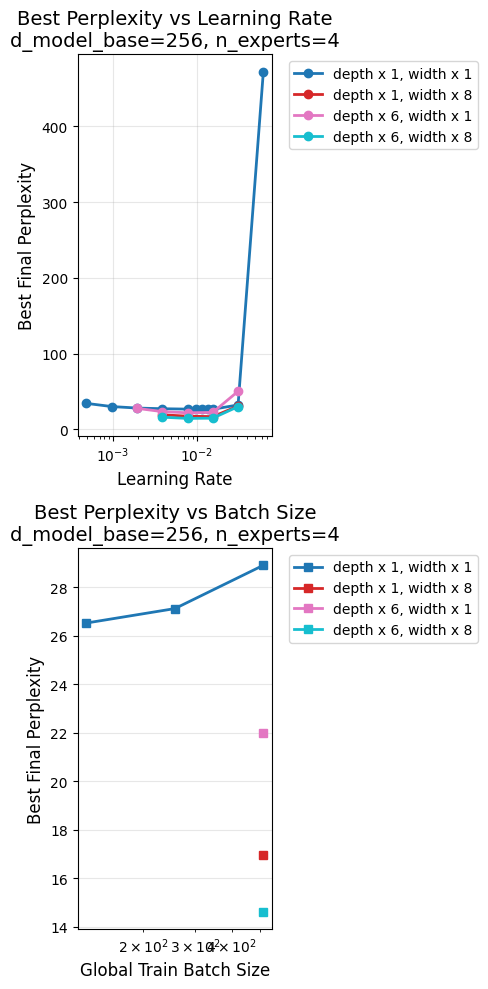

mup_completep_scaling.ipynb - INFO - 
📈 SUMMARY STATISTICS BY BASE CONFIGURATION:
mup_completep_scaling.ipynb - INFO - ======================================================================
mup_completep_scaling.ipynb - INFO - 
🔹 Base config: d_model_base=256, n_experts=4, peri_ln=True, embedding_ln=True, no_bias=True
mup_completep_scaling.ipynb - INFO -    Total runs: 46
mup_completep_scaling.ipynb - INFO -    Best perplexity: 14.6014
mup_completep_scaling.ipynb - INFO -    Best config: depth x 6, width x 8
mup_completep_scaling.ipynb - INFO -    Best LR: 0.0078125
mup_completep_scaling.ipynb - INFO -    Best batch size: 512
mup_completep_scaling.ipynb - INFO -    Perplexity range: 121197.2127
mup_completep_scaling.ipynb - INFO -    Multiplier configs tested: 4
mup_completep_scaling.ipynb - INFO -       • depth x 1, width x 1
mup_completep_scaling.ipynb - INFO -       • depth x 6, width x 1
mup_completep_scaling.ipynb - INFO -       • depth x 1, width x 8
mup_completep_scaling.ipynb -

In [ ]:
# Group the results by base configuration (d_model, n_experts) and then by
# multipliers (depth and width multiplier). For each group, plot the best final
# perplexity versus the learning rate and the final perplexity versus the batch size
# drawing a line for each multipliers configuration in the group.

if results_df.empty:
    log.warning("No results to analyze - results_df is empty")
else:
    log.info("🔍 Starting analysis of grouped results...")

    # Group by base configuration (d_model, n_total_experts)
    base_groups = results_df.groupby(
        [
            "d_model_base",
            "n_total_experts",
            "peri_ln",
            "embedding_ln",
            "no_bias",
        ],
    )

    log.info("Found %d base groups", len(base_groups))

    fig, axes = plt.subplots(2, len(base_groups), figsize=(5 * len(base_groups), 10))

    # Ensure axes is always 2D for consistent indexing
    if len(base_groups) == 1:
        axes = axes.reshape(2, 1)

    for group_idx, (
        (d_model_base_val, n_experts_val, peri_ln_val, embedding_ln_val, no_bias_val),
        base_group_df,
    ) in enumerate(
        base_groups,
    ):
        log.info(
            (
                "📊 Processing base configuration: d_model_base=%s, n_experts=%s,"
                " peri_ln=%s, embedding_ln=%s, no_bias=%s"
            ),
            d_model_base_val,
            n_experts_val,
            peri_ln_val,
            embedding_ln_val,
            no_bias_val,
        )

        # Group by multipliers configuration within this base group
        multiplier_groups = base_group_df.groupby(
            ["depth_multiplier", "width_multiplier"],
        )

        log.info("   Found %d multiplier configurations", len(multiplier_groups))

        # Plot 1: Best final perplexity vs learning rate
        ax1 = axes[0, group_idx]

        # Plot 2: Final perplexity vs batch size
        ax2 = axes[1, group_idx]

        colors = plt.cm.tab10(  # pyright: ignore[reportAttributeAccessIssue]
            np.linspace(0, 1, len(multiplier_groups)),
        )

        for color_idx, ((depth_mult, width_mult), mult_group_df) in enumerate(
            multiplier_groups,
        ):
            label = f"depth x {depth_mult}, width x {width_mult}"
            color = colors[color_idx]

            # For perplexity vs learning rate: group by learning rate and find best
            # (minimum) perplexity
            lr_groups = mult_group_df.groupby("learning_rate")
            lr_values = []
            best_perplexities_lr = []

            for lr, lr_group in lr_groups:
                best_perp = lr_group["final_perplexity"].min()
                lr_values.append(lr)
                best_perplexities_lr.append(best_perp)

            # Sort by learning rate for proper line plotting
            lr_perp_pairs = sorted(zip(lr_values, best_perplexities_lr, strict=True))
            lr_values, best_perplexities_lr = (
                zip(*lr_perp_pairs, strict=True) if lr_perp_pairs else ([], [])
            )

            # Plot learning rate vs best perplexity
            if lr_values:
                ax1.plot(
                    lr_values,
                    best_perplexities_lr,
                    "o-",
                    color=color,
                    label=label,
                    linewidth=2,
                    markersize=6,
                )

            # For perplexity vs batch size: group by batch size and find best (minimum)
            # perplexity
            bs_groups = mult_group_df.groupby("global_train_batch_size")
            bs_values = []
            best_perplexities_bs = []

            for bs, bs_group in bs_groups:
                best_perp = bs_group["final_perplexity"].min()
                bs_values.append(bs)
                best_perplexities_bs.append(best_perp)

            # Sort by batch size for proper line plotting
            bs_perp_pairs = sorted(zip(bs_values, best_perplexities_bs, strict=True))
            bs_values, best_perplexities_bs = (
                zip(*bs_perp_pairs, strict=True) if bs_perp_pairs else ([], [])
            )

            # Plot batch size vs best perplexity
            if bs_values:
                ax2.plot(
                    bs_values,
                    best_perplexities_bs,
                    "s-",
                    color=color,
                    label=label,
                    linewidth=2,
                    markersize=6,
                )

        # Configure first subplot (learning rate vs perplexity)
        ax1.set_xlabel("Learning Rate", fontsize=12)
        ax1.set_ylabel("Best Final Perplexity", fontsize=12)
        ax1.set_title(
            (
                f"Best Perplexity vs Learning Rate\n"
                f"d_model_base={d_model_base_val}, n_experts={n_experts_val}"
            ),
            fontsize=14,
        )
        ax1.set_xscale("log")
        ax1.grid(alpha=0.3)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

        # Configure second subplot (batch size vs perplexity)
        ax2.set_xlabel("Global Train Batch Size", fontsize=12)
        ax2.set_ylabel("Best Final Perplexity", fontsize=12)
        ax2.set_title(
            (
                f"Best Perplexity vs Batch Size\n"
                f"d_model_base={d_model_base_val}, n_experts={n_experts_val}"
            ),
            fontsize=14,
        )
        ax2.set_xscale("log")
        ax2.grid(alpha=0.3)
        ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

        log.info("   ✅ Processed %s multiplier configurations", len(multiplier_groups))

    plt.tight_layout()
    plt.show()

    # Additional analysis: Print summary statistics
    log.info("\n📈 SUMMARY STATISTICS BY BASE CONFIGURATION:")
    log.info("=" * 70)

    for (
        d_model_base_val,
        n_experts_val,
        peri_ln_val,
        embedding_ln_val,
        no_bias_val,
    ), base_group_df in base_groups:
        log.info(
            (
                "\n🔹 Base config: d_model_base=%s, n_experts=%s,"
                " peri_ln=%s, embedding_ln=%s, no_bias=%s"
            ),
            d_model_base_val,
            n_experts_val,
            peri_ln_val,
            embedding_ln_val,
            no_bias_val,
        )
        log.info("   Total runs: %s", len(base_group_df))

        # Best overall perplexity in this base configuration
        best_run = base_group_df.loc[base_group_df["final_perplexity"].idxmin()]
        log.info("   Best perplexity: %.4f", best_run["final_perplexity"])
        log.info(
            "   Best config: depth x %s, width x %s",
            best_run["depth_multiplier"],
            best_run["width_multiplier"],
        )
        log.info("   Best LR: %s", best_run["learning_rate"])
        log.info("   Best batch size: %s", best_run["global_train_batch_size"])

        # Range of perplexities
        perp_range = (
            base_group_df["final_perplexity"].max()
            - base_group_df["final_perplexity"].min()
        )
        log.info("   Perplexity range: %.4f", perp_range)

        # Multiplier configurations tested
        multiplier_configs = base_group_df[
            ["depth_multiplier", "width_multiplier"]
        ].drop_duplicates()
        log.info("   Multiplier configs tested: %s", len(multiplier_configs))
        for _, config in multiplier_configs.iterrows():
            log.info(
                "      • depth x %s, width x %s",
                config["depth_multiplier"],
                config["width_multiplier"],
            )

    log.info("\n✅ Analysis completed successfully!")